# Cifar-10 이미지 분류

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seed = 2021
np.random.rand(seed)
tf.random.set_seed(seed)

### 데이터 전처리

In [3]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape, X_test.shape, y_train.shape

170500096/170498071 [==============================] - 3s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1))

In [4]:
class_names = ['ariplane', 'automobile', 'bird', 'cat', 'dear',
               'dog', 'frog', 'horse', 'ship', 'truck']

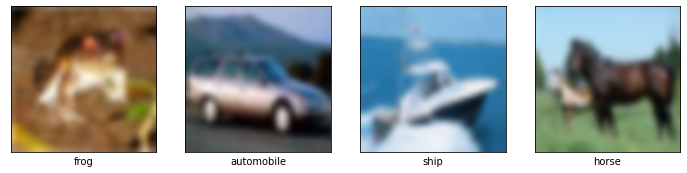

In [5]:
plt.figure(figsize=(12,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_train[i*4], interpolation='bicubic')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[y_train[i*4,0]])
plt.show()

In [6]:
# 자료형을 실수로 변환하고 정규화
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [7]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
Y_train.shape, Y_test.shape

((50000, 10), (10000, 10))

### 모델 정의/설정/학습

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=X_train.shape[1:],    # (32, 32, 3)
           activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),     # pool_size = (2,2)
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),     # pool_size = (2,2)
    Dropout(0.25), 

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')           
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [10]:
# optimizer 설정
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.0001, decay=1e-6)

In [11]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [12]:
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

In [13]:
model_path = MODEL_DIR + 'best-cifar10-cnn.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(patience=10)

In [14]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=100,
                    validation_split=0.2,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
1250/1250 [==============================] - 40s 6ms/step - loss: 2.0563 - accuracy: 0.2354 - val_loss: 1.6237 - val_accuracy: 0.4207

Epoch 00001: val_loss improved from inf to 1.62373, saving model to ./model/best-cifar10-cnn.hdf5
Epoch 2/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.6152 - accuracy: 0.4077 - val_loss: 1.4815 - val_accuracy: 0.4662

Epoch 00002: val_loss improved from 1.62373 to 1.48145, saving model to ./model/best-cifar10-cnn.hdf5
Epoch 3/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.4507 - accuracy: 0.4745 - val_loss: 1.3586 - val_accuracy: 0.5234

Epoch 00003: val_loss improved from 1.48145 to 1.35859, saving model to ./model/best-cifar10-cnn.hdf5
Epoch 4/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.3559 - accuracy: 0.5117 - val_loss: 1.2392 - val_accuracy: 0.5703

Epoch 00004: val_loss improved from 1.35859 to 1.23920, saving model to ./model/best-cifar10-cnn.hdf5
Epoch 5/100

In [15]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

In [16]:
# 정확도
acc = best_model.evaluate(X_test, Y_test)
print(f'정확도: {acc[1]:.4f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.6371 - accuracy: 0.7868
정확도: 0.7868


### 훈련과정 시각화

In [17]:
# 훈련셋과 검증셋의 오차
y_loss = history.history['loss']
y_vloss = history.history['val_loss']

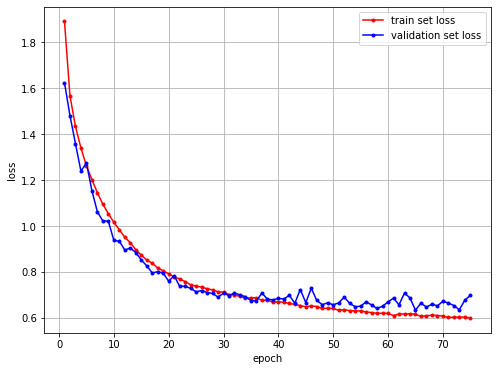

In [18]:
x_len = np.arange(1, len(y_loss)+1)
plt.figure(figsize=(8,6))
plt.plot(x_len, y_loss, c='red', marker='.', label='train set loss')
plt.plot(x_len, y_vloss, c='blue', marker='.', label='validation set loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()